In [46]:
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px
import numpy as np
import tqdm
import itertools

In [2]:
F1 = Image.open("images_synthetiques/1.png").convert("L")
F2 = Image.open("images_synthetiques/2.png").convert("L")
print(F1.size)
print(F1.mode)

(600, 600)
L


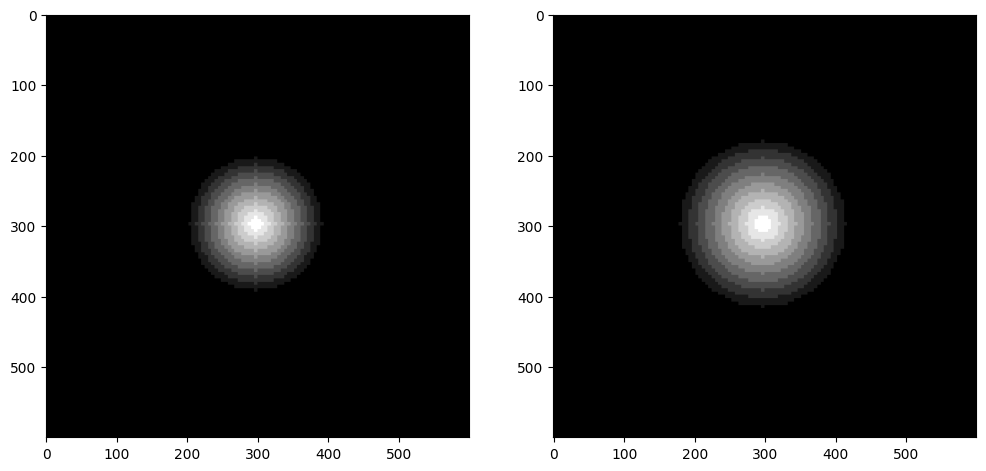

In [3]:
_, ax = plt.subplots(1,2, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
plt.show()

In [4]:
F1 = np.asarray(F1)
F2 = np.asarray(F2)
# F1 = np.flip(F1,0)
# F2 = np.flip(F2,0)
F1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [111]:
def reconstruct(image, displacementX, displacementY):
    x,y = np.meshgrid(np.arange(600), np.arange(600))
    res = image[x - displacementX, y - displacementY]
    return res

# def reconstruct(image, displacementX, displacementY):
#     res = np.copy(image)
#     for x in range(600):
#         for y in range(600):
#             res[x + displacementX[x,y], y + displacementY[x,y]] = image[x, y]
#     return res

In [95]:
def reconstruct_block(image, displacementX, displacementY, block_size):
    x,y = np.meshgrid(np.arange(600), np.arange(600))
    full_Dx = displacementX.repeat(block_size, axis=0).repeat(block_size, axis=1)
    full_Dy = displacementY.repeat(block_size, axis=0).repeat(block_size, axis=1)
    res = image[x - full_Dx, y - full_Dy]
    return res

In [6]:
def find_new(y, x, r):
    if F1[x,y] == F2[x,y]:
        return (0,0)
    point = None
    lowest = None
    d = None
    for x2 in range(max(0, x-r), min(F1.shape[0], x + r)):
        for y2 in range(max(0, y-r), min(F1.shape[1], y + r)):
            diff = abs(F1[x,y].astype(int) - F2[x2,y2].astype(int))
            if not point or diff < lowest:
                lowest = diff
                point = (x2,y2)
                d = (x - x2) ** 2 + (y - y2) ** 2
                #print(f"new point: {point}")
            elif diff == lowest:
                d2 = (x - x2) ** 2 + (y - y2) ** 2
                if d > d2:
                    d = d2
                    point = (x2,y2)
                    #print(f"d = {d}, d2 = {d2}, point = {point}")
    return (point[0] - x, point[1] - y)

In [49]:
Dx = np.array([[0] * F1.shape[0]] * F1.shape[1])
Dy = np.array([[0] * F1.shape[0]] * F1.shape[1])

for i,j in tqdm.tqdm(itertools.product(range(600), range(600)), total=600*600):
    Dx[i,j], Dy[i,j] = find_new(i,j,20)

100%|██████████| 360000/360000 [01:17<00:00, 4643.98it/s]   


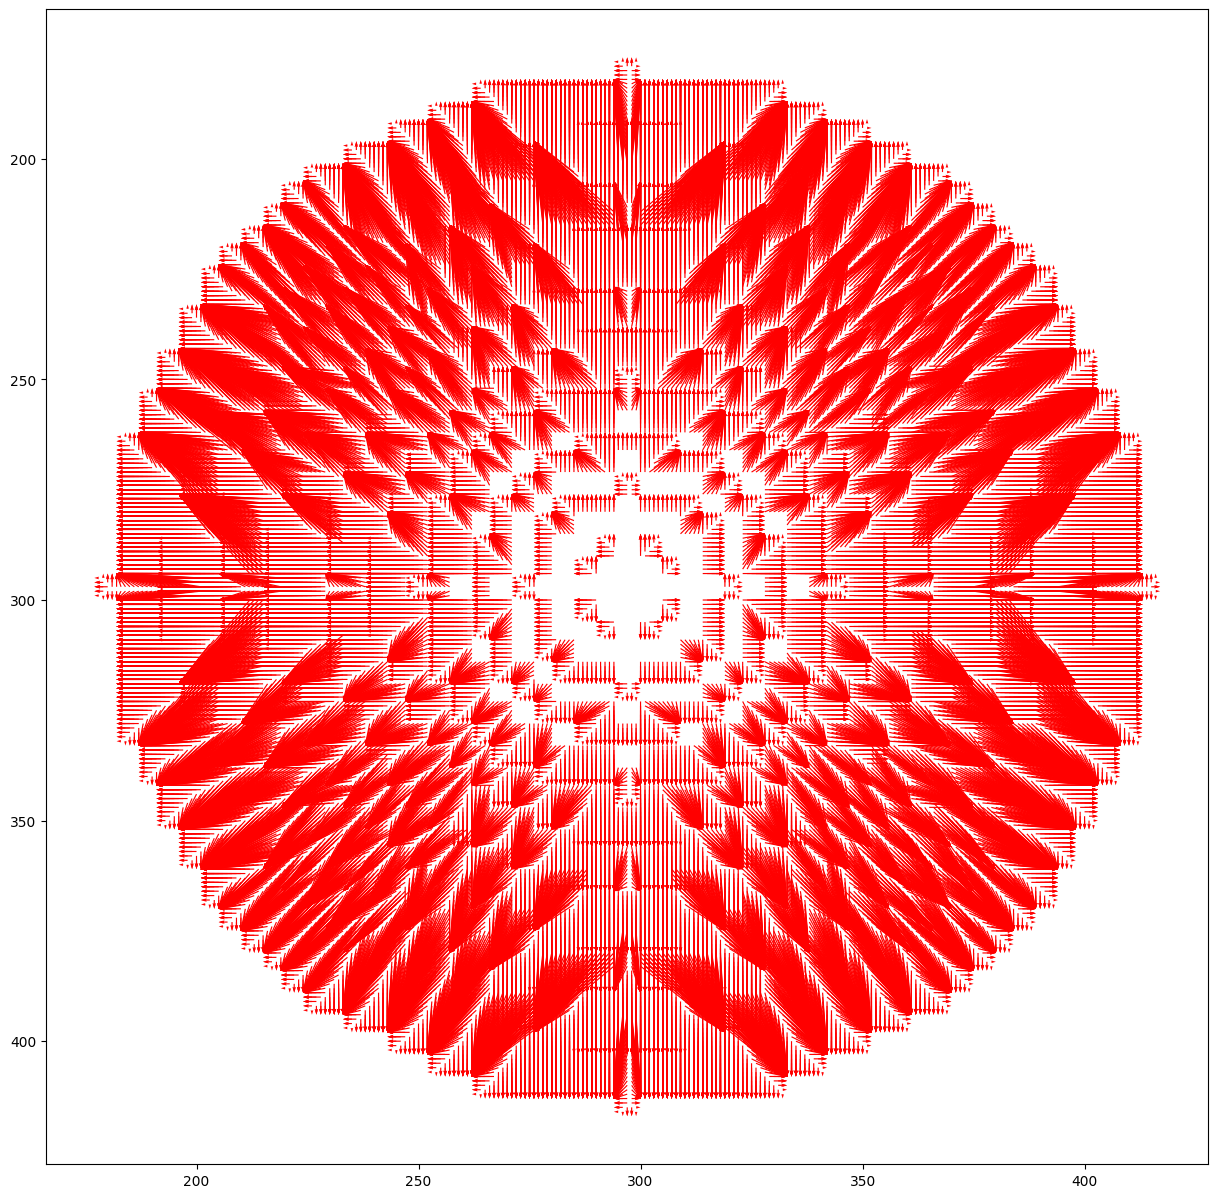

In [50]:
H, W = Dx.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

condition =  (Dx != 0) | (Dy != 0)
non_zero = np.where(condition)

testx = np.ones((H, W))
testy = np.zeros((H, W))


plt.figure(figsize=(15,15))
plt.gca().invert_yaxis()

plt.quiver(X[non_zero], Y[non_zero],
           Dx[non_zero], Dy[non_zero],
           color='red', angles='xy', scale_units='xy', scale=1, width=0.001)

#plt.xlim(0,600)
#plt.ylim(0,600)
fig = px.imshow(F2, color_continuous_scale="gray")
fig.update_layout(
    title="Hover to see pixel coordinates",
    xaxis_title="X",
    yaxis_title="Y"
)
fig.update_traces(hovertemplate="x: %{x}<br>y: %{y}<br>value: %{z}")

# for x0, y0, dx, dy in zip(X[non_zero], Y[non_zero], Dx[non_zero], Dy[non_zero]):
#     fig.add_annotation(
#         x=x0 + dx, y=y0 + dy,
#         ax=x0, ay=y0,
#         xref="x", yref="y", axref="x", ayref="y",
#         showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=1, arrowcolor="red"
#     )

fig.show()

In [53]:
print(Dx[300, 200:220])
print(Dy[300, 200:220])
print(F1[300,200:220])
print(F2[300,200:220])

[-18 -19 -20 -12 -13 -14 -15 -16 -17 -18 -19 -20 -16 -17 -18 -19 -11 -12
 -13 -14]
[ 0  0  0  0  0  0  0  0  0  0  0  0 19 19 19 19  0  0  0  0]
[ 0  0  0  0  0  0 25 25 25 25 25 25 25 25 25 25 51 51 51 51]
[ 51  51  51  51  51  51  76  76  76  76  76  76  76  76  76  76 102 102
 102 102]


In [9]:
Y[non_zero]

array([178, 178, 178, ..., 416, 416, 416])

In [10]:
X[non_zero]

array([295, 296, 297, ..., 297, 298, 299])

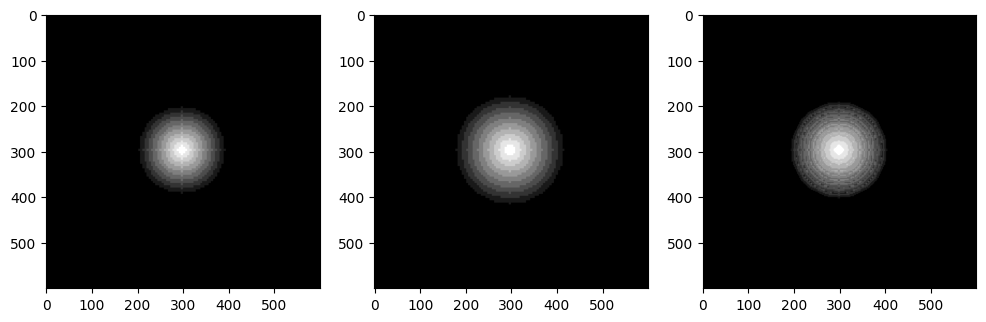

In [112]:
reconstructed = reconstruct(F1, Dx, Dy)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed, cmap='gray')
plt.show()

In [54]:
reconstructed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [55]:
def intensity_B(M, x, y, block_size, offsetx=0, offsety=0):
    startx = x * block_size + offsetx
    starty = y * block_size + offsety
    endx = x * (block_size + 1) + offsetx
    endy = y * (block_size + 1) + offsety
    return M[startx: endx, starty:endy].astype(int).sum()

def find_new_block(by, bx, r, block_size):
    I = intensity_B(F1, bx, by, block_size)
    if I == intensity_B(F2, bx, by, block_size):
        return (0,0)
    point = None
    lowest = None
    d = None
    for offx in range(-r + 1, r):
        if bx * block_size - offx < 0 or bx * block_size + offx > 600:
            continue
        for offy in range(-r + 1, r):
            if by * block_size - offy < 0 or by * block_size + offy > 600:
                continue
            diff = abs(I - intensity_B(F2, bx ,by, block_size, offx, offy))
            if not point or diff < lowest:
                lowest = diff
                point = (bx * block_size + offx, by * block_size + offy)
                d = offx ** 2 + offy ** 2
                #print(f"new point: {point}")
            elif diff == lowest:
                d2 = offx ** 2 + offy ** 2
                if d > d2:
                    d = d2
                    point = (bx * block_size + offx, by * block_size + offy)
                    #print(f"d = {d}, d2 = {d2}, point = {point}")
    return (point[0] - bx * block_size, point[1] - by * block_size)

In [156]:
#Block based

n_blocks = 30
block_size = 600 // n_blocks

B_Dx = np.array([[0] * n_blocks] * n_blocks)
B_Dy = np.array([[0] * n_blocks] * n_blocks)

for i in range(n_blocks):
    for j in range(n_blocks):
        B_Dx[i,j], B_Dy[i,j] = find_new_block(i, j, 20, block_size)
B_Dx

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,

In [57]:
B_Dx[17, 14]

np.int64(-7)

In [58]:
B_Dy[17,14]

np.int64(7)

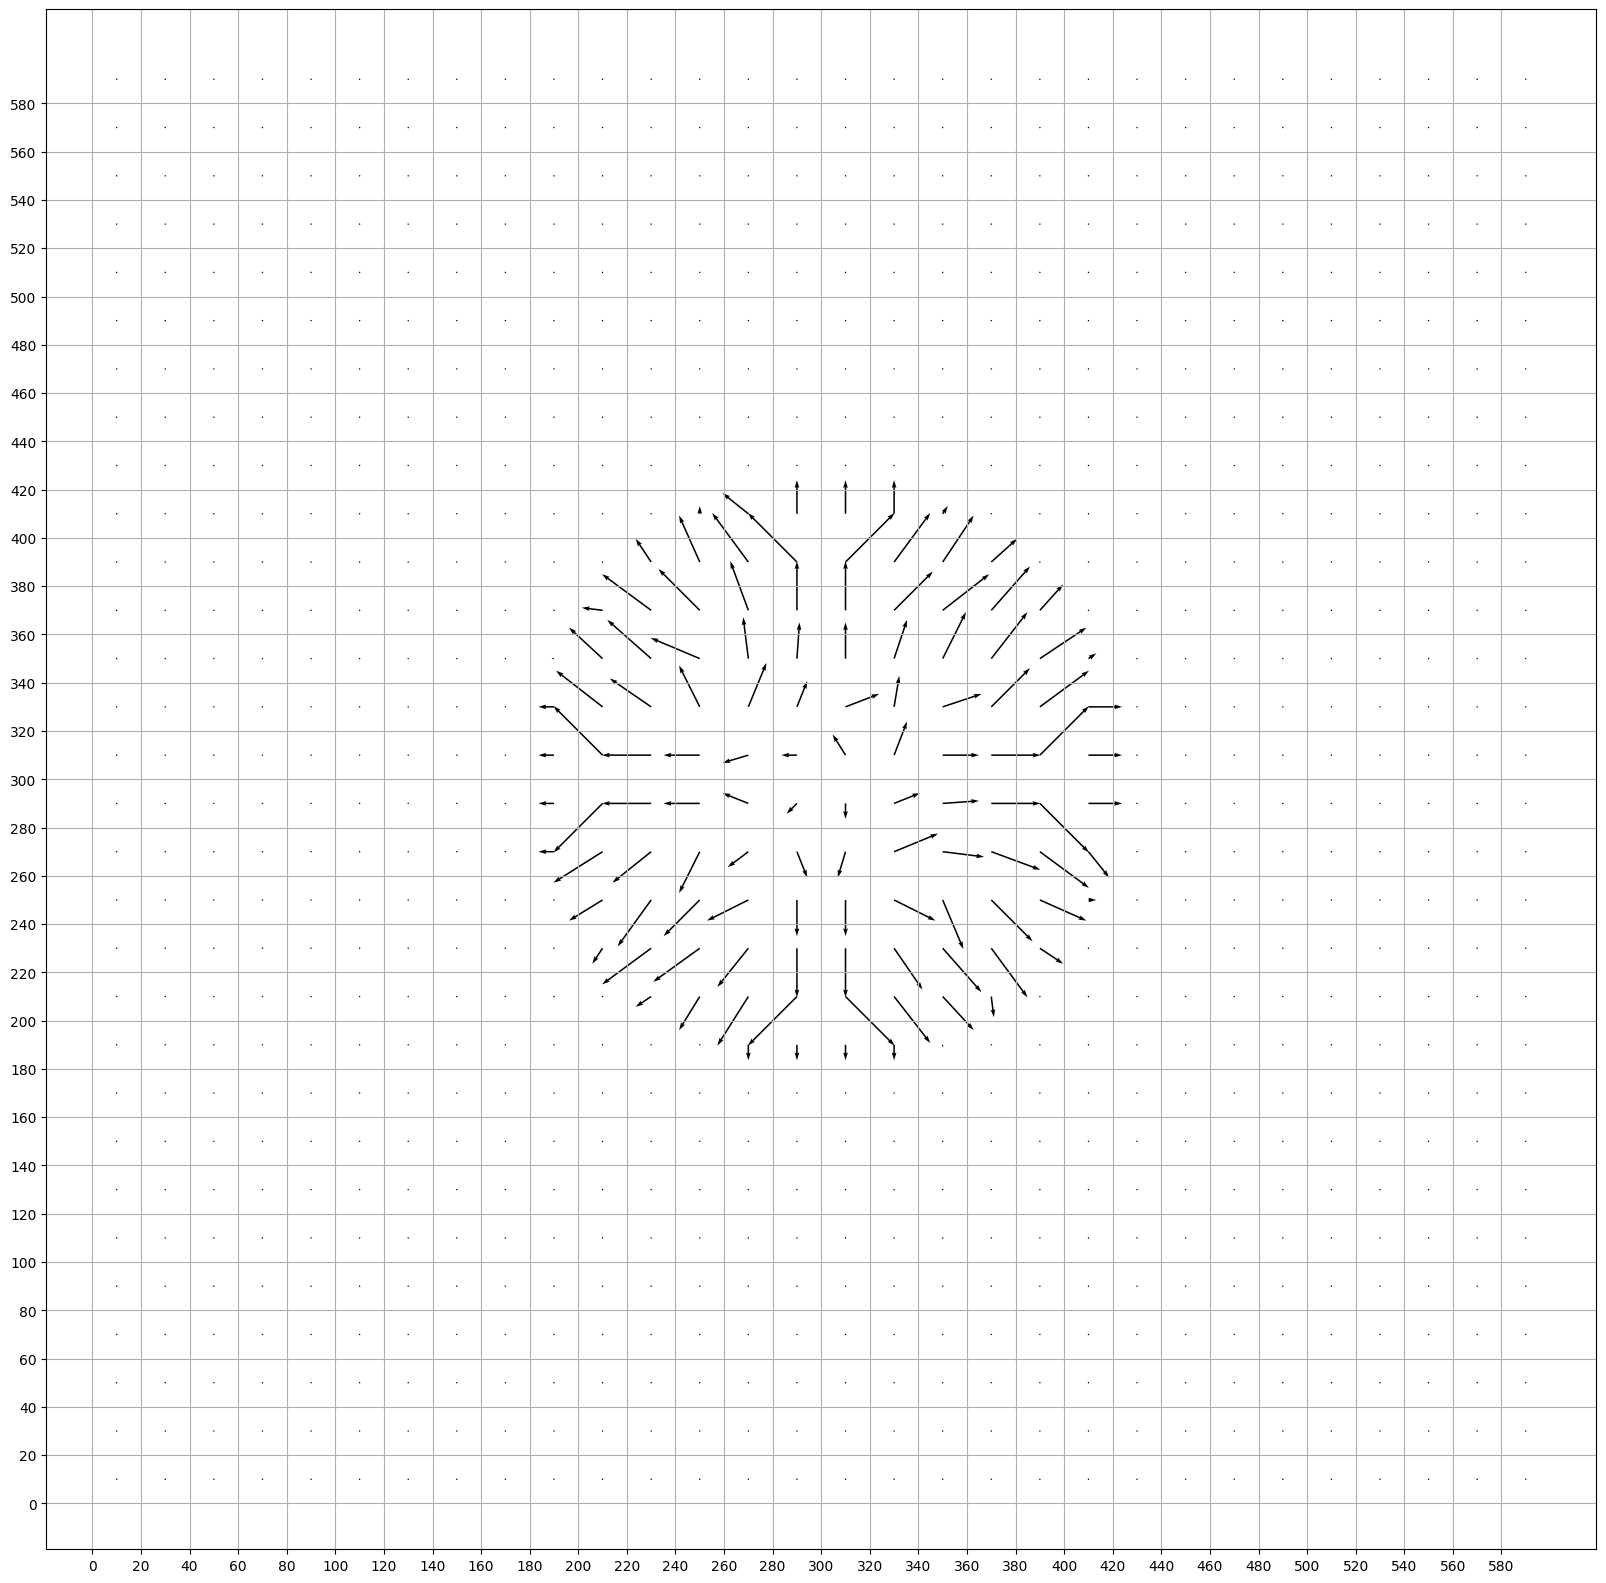

In [157]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(n_blocks) * block_size)
ax.set_yticks(np.arange(n_blocks) * block_size)
ax.grid()
O_x = np.tile(np.arange(block_size // 2, block_size * n_blocks, block_size), n_blocks)
O_y = np.arange(block_size // 2, block_size * n_blocks, block_size).repeat(n_blocks)
ax.quiver(O_x.flatten(), O_y.flatten(), B_Dx, B_Dy, scale=600, width=0.001)
plt.show()

In [92]:
np.array([[1,2,3], [4,5,6]]).repeat(2, axis=0).repeat(2,axis=1)

array([[1, 1, 2, 2, 3, 3],
       [1, 1, 2, 2, 3, 3],
       [4, 4, 5, 5, 6, 6],
       [4, 4, 5, 5, 6, 6]])

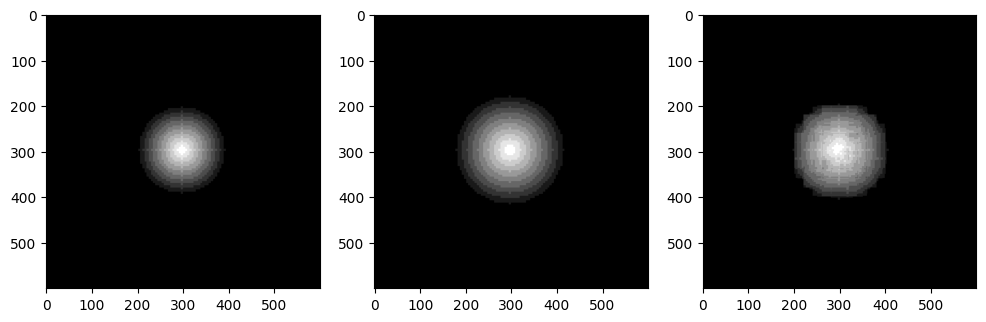

In [158]:
reconstructed_smoothed = reconstruct_block(F1, B_Dx, B_Dy, block_size)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_smoothed, cmap='gray')
plt.show()

### Question C:

On peut remarquer que le champ est plus régulier avec des blocs plus grands.

In [60]:
# Node Based:


# Régularisation: 

In [165]:
#On défini la fonction d'erreur
def error(dx, dy):
    F2_predicted = np.array([[0] * F1.shape[0]] * F1.shape[1])
    for i in range(600):
        for j in range(600):
            F2_predicted[i,j] = F2[i + dy[i,j],j + dx[i,j]]
    return abs(F1 - F2_predicted)

In [ ]:
#On initialise 
#Dx_smoothed = np.array([[0.0] * F1.shape[0]] * F1.shape[1])
#Dy_smoothed = np.array([[0.0] * F1.shape[0]] * F1.shape[1])

Dx_smoothed = np.copy(Dx).astype('float')
Dy_smoothed = np.copy(Dy).astype('float')

#for bounds when calculating:
X, Y = np.meshgrid(np.arange(600), np.arange(600))

#On calcul avec régularisation à travers le gradient
# iters = 100
# coef = 0.05
# for i in range(iters):
#     E = error(np.rint(Dx_smoothed).astype(int), np.rint(Dy_smoothed).astype(int))
#     grad = np.gradient(E)
#     print(E.sum())

#     Dx_smoothed = np.clip(Dx_smoothed - (coef * grad[1]), -X, 599 - X)
#     Dy_smoothed = np.clip(Dy_smoothed - (coef * grad[0]), -Y, 599 - Y)
#     #Dx_smoothed -= (coef * grad[1])
#     #Dy_smoothed -= (coef * grad[0])

coef = 0.01
iters = 50
smooth_coef = 0.01
for i in range(iters):
    gradX = np.gradient(Dx_smoothed)
    gradY = np.gradient(Dy_smoothed)

    gradX = np.square(gradX[0]) + np.square(gradX[1])
    gradY = np.square(gradY[0]) + np.square(gradY[1])

    E = error(np.rint(Dx_smoothed).astype(int), np.rint(Dy_smoothed).astype(int))
    grad = np.gradient(E)
    
    total_grad_Dx = grad[1] + smooth_coef * gradX
    total_grad_Dy = grad[0] + smooth_coef * gradY

    Dx_smoothed = np.clip(Dx_smoothed - (coef * total_grad_Dx), -X, 599 - X)
    Dy_smoothed = np.clip(Dy_smoothed - (coef * total_grad_Dy), -Y, 599 - Y)
    
    print(E.sum())

    #Dx_smoothed = np.clip(Dx_smoothed - (coef * grad[1]), -X, 599 - X)
    #Dy_smoothed = np.clip(Dy_smoothed - (coef * grad[0]), -Y, 599 - Y)
    #Dx_smoothed -= (coef * grad[1])
    #Dy_smoothed -= (coef * grad[0])

[[  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]
 ...
 [  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]]
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [597 597 597 ... 597 597 597]
 [598 598 598 ... 598 598 598]
 [599 599 599 ... 599 599 599]]
10400
10400
10400
10400
13104
14560
14560
14560
15912
17264
17264
17264
18616
20072
19968
19968
21320
22724
22776
22724
24024
25324
25324
25324
26520
27560
27872
27818
29222
30210
29684
29940
31240
32330
32790
33040
34390
35530
35938
36190
37490
37592
38784
39192
40544
40694
40846
41896
43496
43596


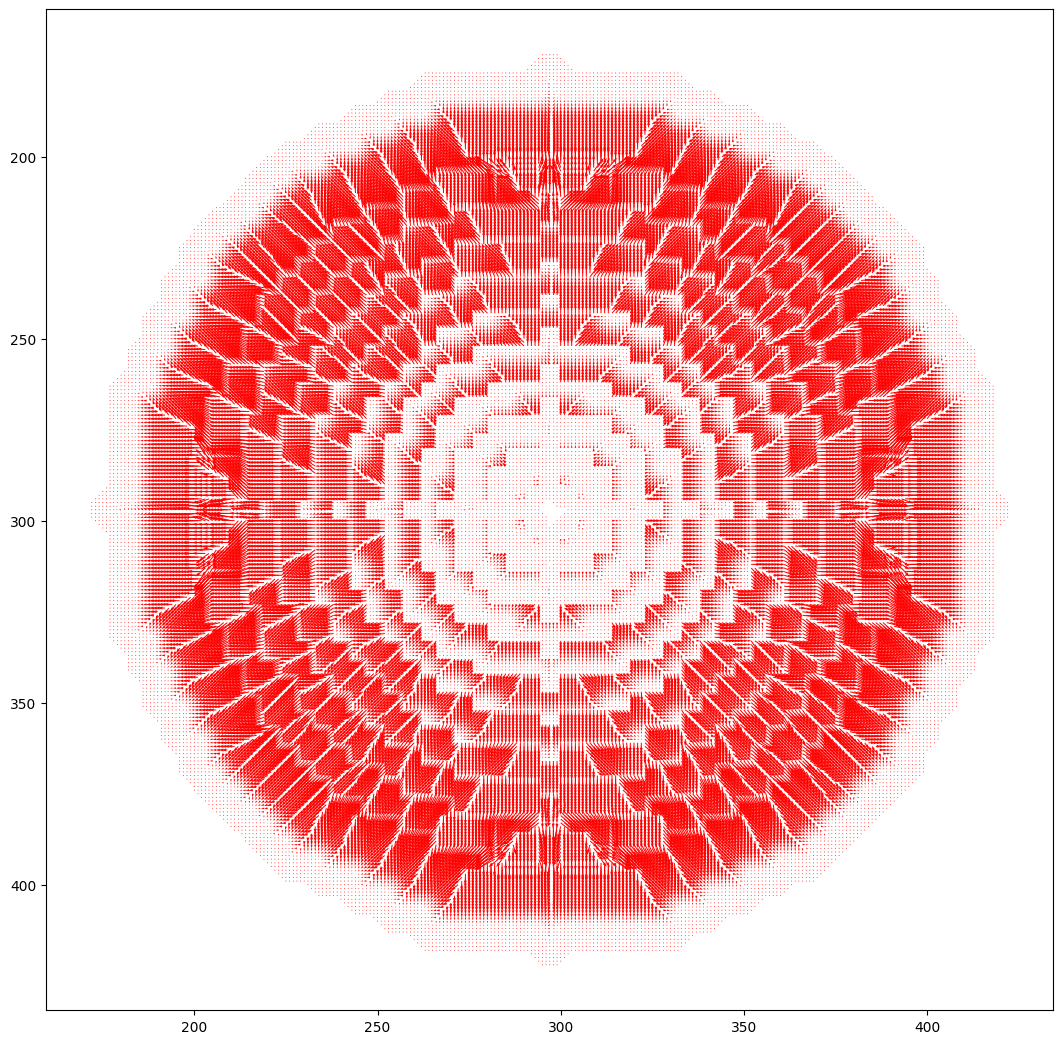

In [167]:
H, W = Dx_smoothed.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

condition =  (Dx_smoothed != 0) | (Dy_smoothed != 0)
non_zero = np.where(condition)


plt.figure(figsize=(13,13))
plt.gca().invert_yaxis()
plt.quiver(X[non_zero], Y[non_zero],
           Dx_smoothed[non_zero], Dy_smoothed[non_zero],
           color='red', angles='xy', scale_units='xy', scale=5, width=0.001)
#plt.xlim(0,600)
#plt.ylim(0,600)
plt.show()

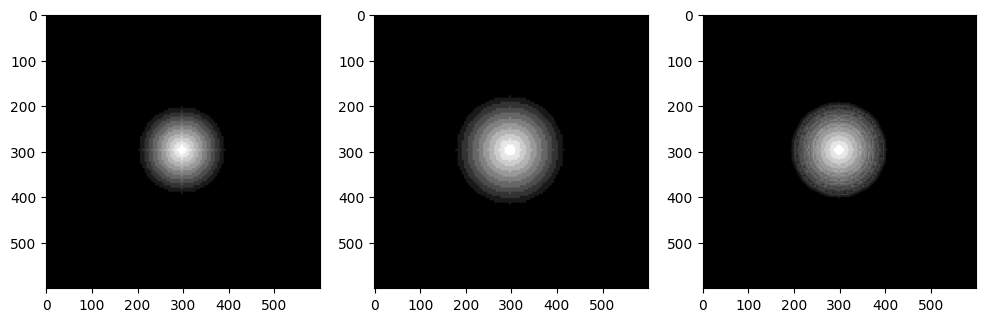

In [168]:
reconstructed_smoothed = reconstruct(F1, Dx_smoothed.round().astype(int), Dy_smoothed.round().astype(int))

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_smoothed, cmap='gray')
plt.show()

Block avec régularisation:

In [ ]:
#Calculer d avec pixelwise
#Pour chaque iter:
    #calculer grad et ajouter avec un poids

Pr tp2:

backwards comme forward juste en inversant I1 et I2 -> I1(x + dx, y + dy) - I2(x, y)